In [13]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random

import warnings
warnings.filterwarnings('ignore')

In [14]:
model = api.load("word2vec-google-news-300")

In [15]:
print(model.most_similar(
	positive=["king", "woman"], 
	negative=["man"]
)[0][0])

print(model.most_similar(
	positive=["boy"], 
	negative=["girl"]
)[0][0])

print(model.most_similar(
	positive=["actor", "woman"], 
	negative=["boy"]
)[0][0])

print(model.most_similar(
	positive=["vehicle", "slow"], 
	negative=["fast"]
)[0][0])

print(model.most_similar(
	positive=["fast", "run", "human"]
)[0][0])

queen
boyhood
actress
SUV
running


In [16]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [17]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/ 

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


^C


Summary Statistics for Word Count:
count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: word_count, dtype: float64


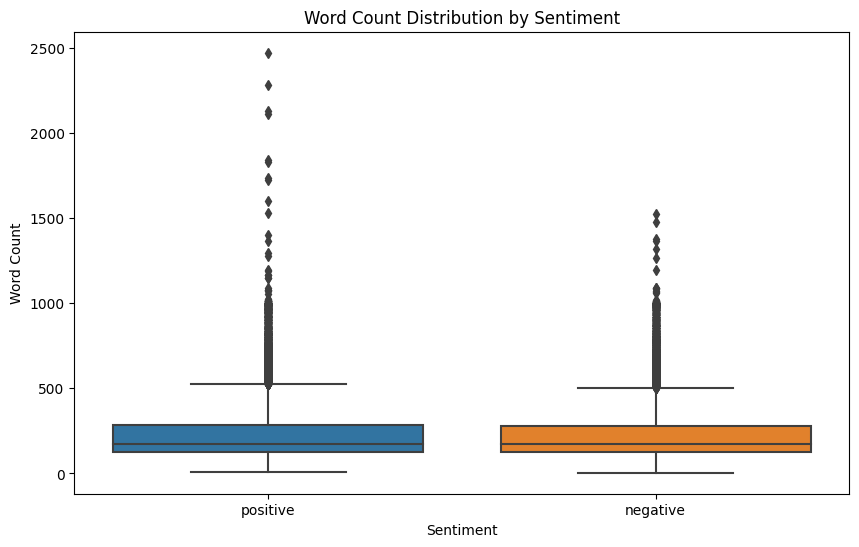

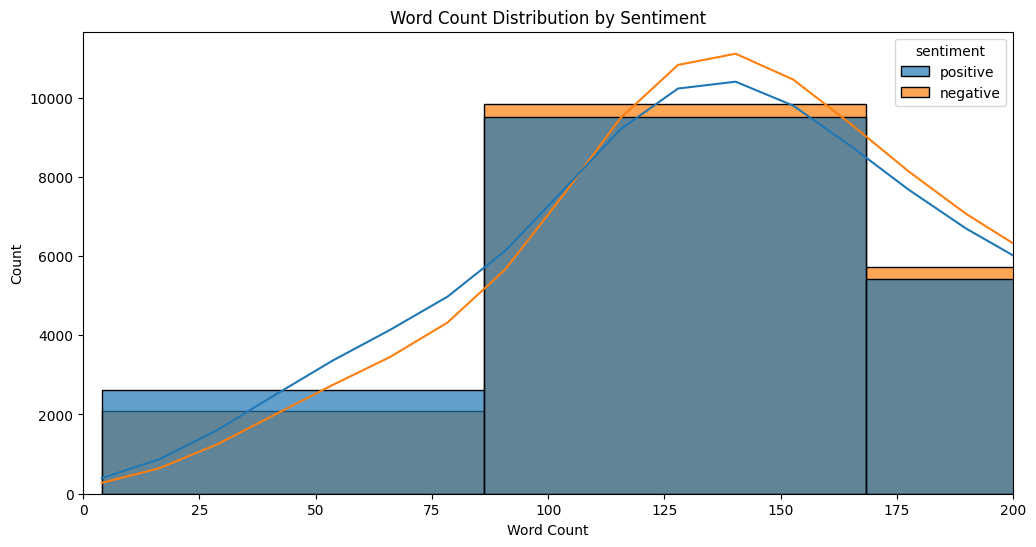

In [18]:
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

print("Summary Statistics for Word Count:")
print(df['word_count'].describe())

plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='word_count', data=df)
plt.title('Word Count Distribution by Sentiment')
plt.ylabel('Word Count')
plt.xlabel('Sentiment')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='sentiment', bins=30, alpha=0.7, kde=True)
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Word Count')
plt.xlim(0, 200)
plt.show()

Top 10 Unigrams by Sentiment:


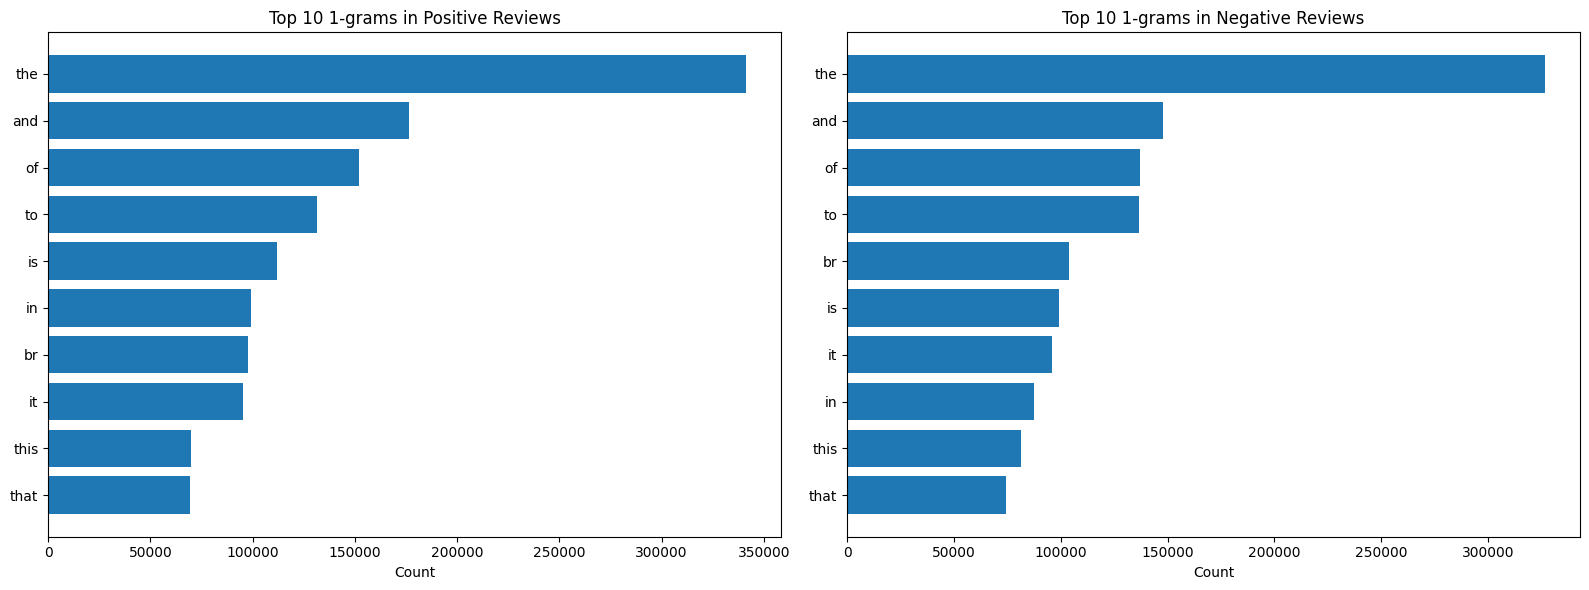

Top 10 Bigrams by Sentiment:


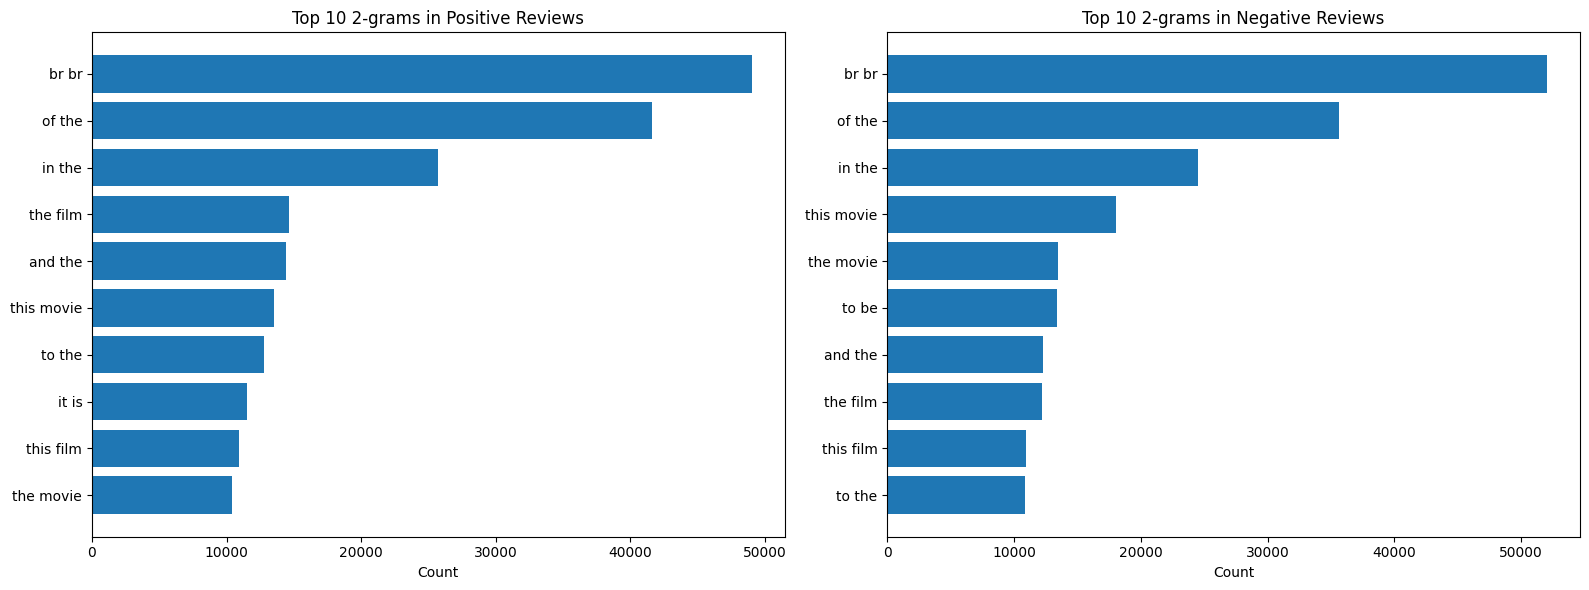

Top 10 Trigrams by Sentiment:


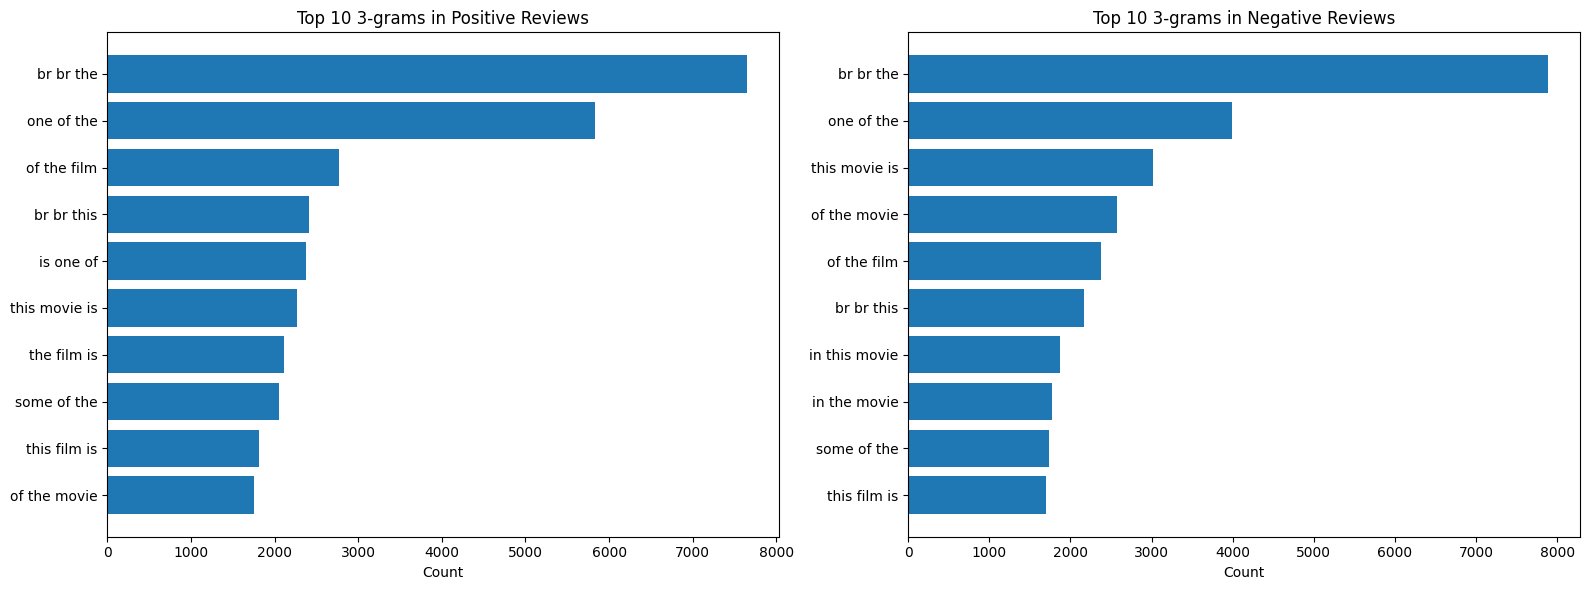

In [19]:
def get_top_ngrams(corpus, n, top_k):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

def plot_top_ngrams(df, n, top_k=10):
    pos_reviews = df[df['sentiment'] == 'positive']['review']
    neg_reviews = df[df['sentiment'] == 'negative']['review']
    
    pos_ngrams = get_top_ngrams(pos_reviews, n, top_k)
    neg_ngrams = get_top_ngrams(neg_reviews, n, top_k)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    axes[0].barh([x[0] for x in pos_ngrams][::-1], [x[1] for x in pos_ngrams][::-1])
    axes[0].set_title(f'Top {top_k} {n}-grams in Positive Reviews')
    axes[0].set_xlabel('Count')
    
    axes[1].barh([x[0] for x in neg_ngrams][::-1], [x[1] for x in neg_ngrams][::-1])
    axes[1].set_title(f'Top {top_k} {n}-grams in Negative Reviews')
    axes[1].set_xlabel('Count')
    
    plt.tight_layout()
    plt.show()

print("Top 10 Unigrams by Sentiment:")
plot_top_ngrams(df, 1, 10)

print("Top 10 Bigrams by Sentiment:")
plot_top_ngrams(df, 2, 10)

print("Top 10 Trigrams by Sentiment:")
plot_top_ngrams(df, 3, 10)

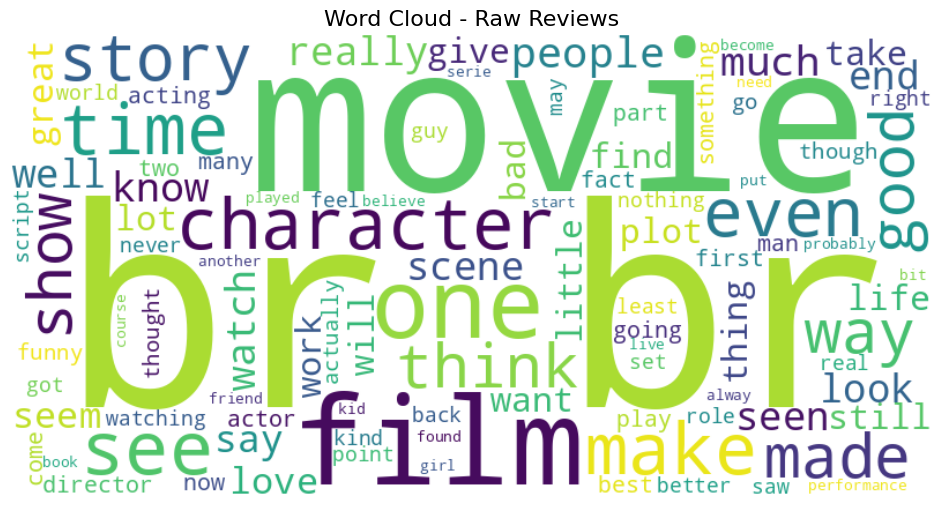

In [30]:
from wordcloud import WordCloud

def plot_wordcloud(text, title, max_words=100):
    wordcloud = WordCloud(width=800, height=400, max_words=max_words, background_color='white').generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Before Preprocessing
raw_text = ' '.join(df['review'].astype(str).tolist())
plot_wordcloud(raw_text, "Word Cloud - Raw Reviews")


In [20]:
def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
        
    text = text.lower()
    
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    text = text.replace("br", "").replace("<", "").replace(">", "")

    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

df['processed_text'] = df['review'].apply(preprocess_text)

print("Original vs Preprocessed Text:")
for i in range(3):
    print(f"\nOriginal: {df['review'].iloc[i][:100]}...")
    print(f"Processed: {df['processed_text'].iloc[i][:100]}...")

Original vs Preprocessed Text:

Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The...
Processed: one reviewer mentioned watching oz episode youll hooked right exactly happened first thing struck oz...

Original: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-B...
Processed: wonderful little production filming technique unassuming oldtimebbc fashion give comforting sometime...

Original: I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air con...
Processed: thought wonderful way spend time hot summer weekend sitting air conditioned theater watching lighthe...


Top 10 Unigrams by Sentiment:


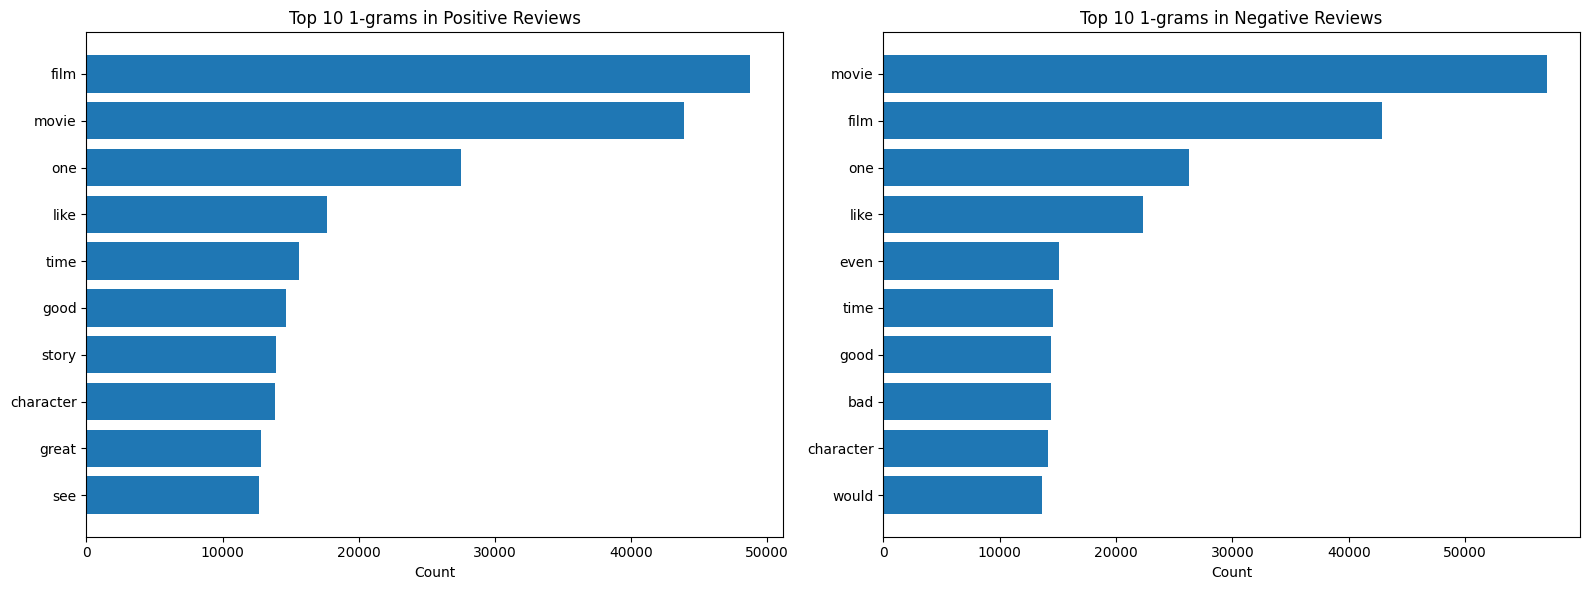

Top 10 Bigrams by Sentiment:


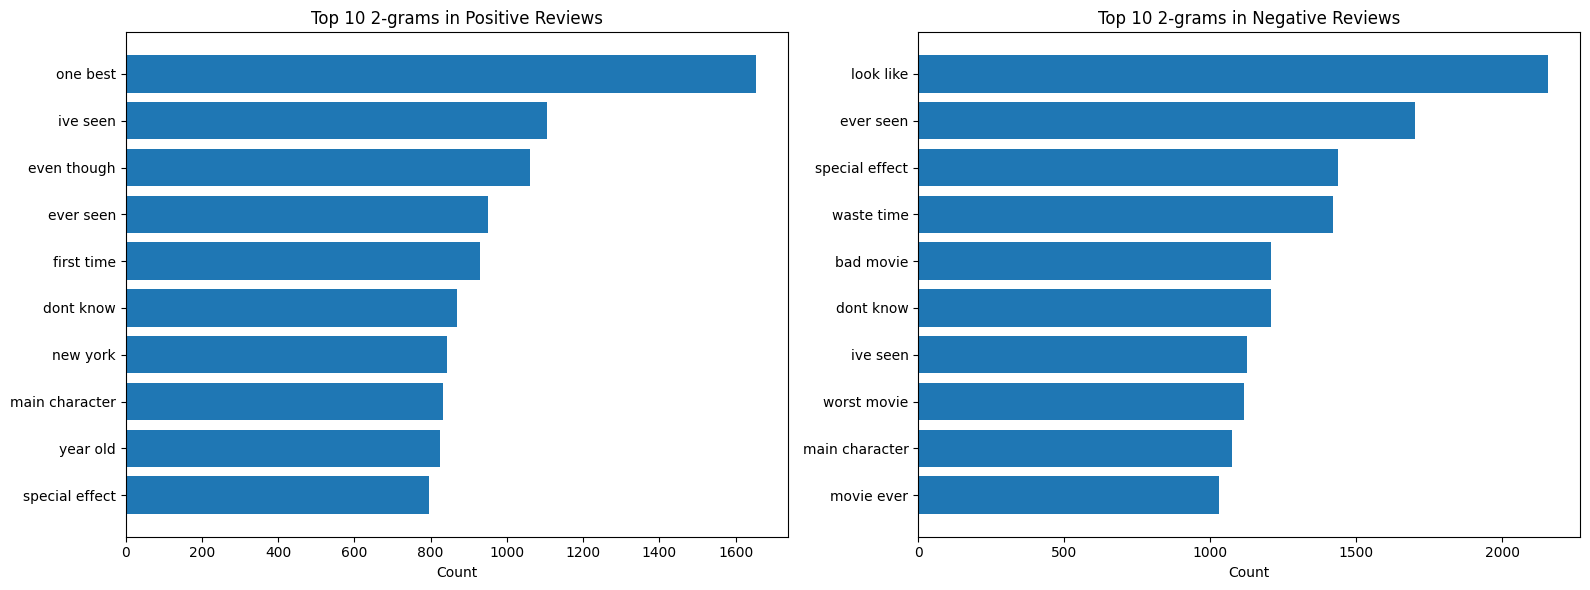

Top 10 Trigrams by Sentiment:


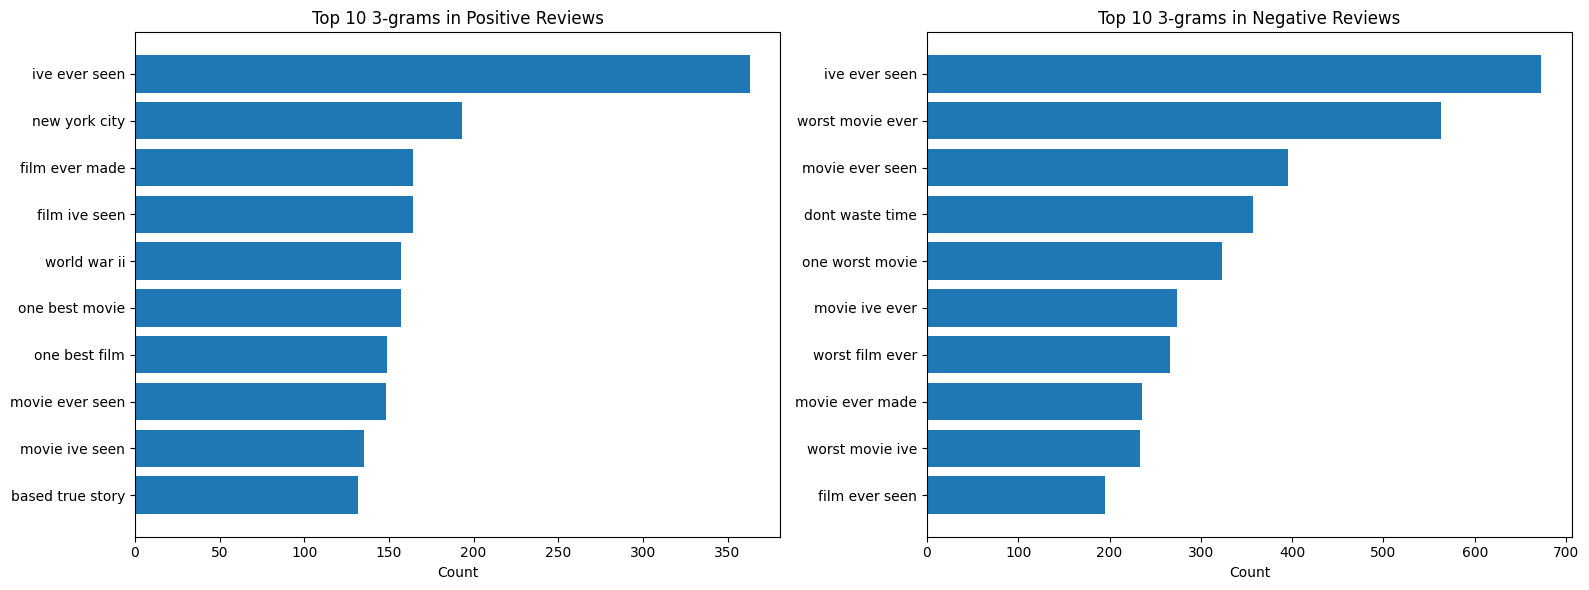

In [22]:
def get_top_ngrams(corpus, n, top_k):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

def plot_top_ngrams(df, n, top_k=10):
    pos_reviews = df[df['sentiment'] == 'positive']['processed_text']
    neg_reviews = df[df['sentiment'] == 'negative']['processed_text']
    
    pos_ngrams = get_top_ngrams(pos_reviews, n, top_k)
    neg_ngrams = get_top_ngrams(neg_reviews, n, top_k)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    axes[0].barh([x[0] for x in pos_ngrams][::-1], [x[1] for x in pos_ngrams][::-1])
    axes[0].set_title(f'Top {top_k} {n}-grams in Positive Reviews')
    axes[0].set_xlabel('Count')
    
    axes[1].barh([x[0] for x in neg_ngrams][::-1], [x[1] for x in neg_ngrams][::-1])
    axes[1].set_title(f'Top {top_k} {n}-grams in Negative Reviews')
    axes[1].set_xlabel('Count')
    
    plt.tight_layout()
    plt.show()

print("Top 10 Unigrams by Sentiment:")
plot_top_ngrams(df, 1, 10)

print("Top 10 Bigrams by Sentiment:")
plot_top_ngrams(df, 2, 10)

print("Top 10 Trigrams by Sentiment:")
plot_top_ngrams(df, 3, 10)

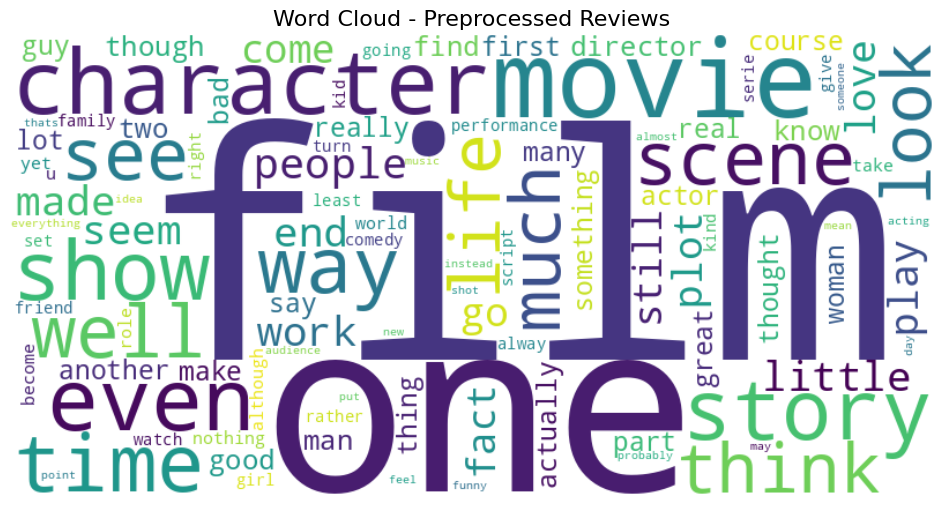

In [31]:
# After Preprocessing
clean_text = ' '.join(df['processed_text'].astype(str).tolist())
plot_wordcloud(clean_text, "Word Cloud - Preprocessed Reviews")

In [23]:
tokenized_reviews = df['processed_text'].apply(lambda x: x.split()).tolist()

In [24]:
import numpy as np

def get_avg_w2v_vector(tokens, wv_model, vector_size=300):
    vectors = [wv_model[word] for word in tokens if word in wv_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

df['w2v_vector'] = df['processed_text'].apply(lambda x: get_avg_w2v_vector(x.split(), model))

In [25]:
from gensim.models import Word2Vec

skipgram_model = Word2Vec(sentences=tokenized_reviews, 
                          sg=1, vector_size=100, 
                          window=3, 
                          min_count=2, 
                          workers=4)
df['skipgram_vector'] = df['processed_text'].apply(lambda x: get_avg_w2v_vector(x.split(), skipgram_model.wv, 100))

In [26]:
cbow_model = Word2Vec(sentences=tokenized_reviews, 
                      sg=0, 
                      vector_size=100, 
                      window=3, 
                      min_count=2, 
                      workers=4)
df['cbow_vector'] = df['processed_text'].apply(lambda x: get_avg_w2v_vector(x.split(), cbow_model.wv, 100))

In [27]:
from gensim.models import FastText

fasttext_model = FastText(sentences=tokenized_reviews, 
                          sg=1, 
                          vector_size=100, 
                          window=3, 
                          min_count=2, 
                          workers=4)
df['fasttext_vector'] = df['processed_text'].apply(lambda x: get_avg_w2v_vector(x.split(), fasttext_model.wv, 100))

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def train_and_evaluate(X_vectors, y):
    X = np.vstack(X_vectors)
    y = y.map({'positive': 1, 'negative': 0})
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))

print("Performance with Pre-trained W2V:")
train_and_evaluate(df['w2v_vector'], df['sentiment'])

print("Performance with Skip-gram:")
train_and_evaluate(df['skipgram_vector'], df['sentiment'])

print("Performance with CBoW:")
train_and_evaluate(df['cbow_vector'], df['sentiment'])

print("Performance with FastText:")
train_and_evaluate(df['fasttext_vector'], df['sentiment'])

Performance with Pre-trained W2V:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5000
           1       0.86      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Performance with Skip-gram:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5000
           1       0.87      0.88      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Performance with CBoW:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      5000
           1       0.85      0.86      0.86      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85